- https://www.adrianbulat.com/downloads/FG20/fast_human_pose.pdf
- https://arxiv.org/pdf/1603.06937.pdf (Figure 4)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import torch
sys.path.append("/home/michael/CascadedPoseEstimation/lib")
from core.config import config
from core.config import update_config

In [73]:
import models.pose_resnet
import models.unet
import models.cascaded_pose_resnet
import models.pose_stacked_hg
import torch.nn as nn
from typing import Dict, Iterable, Callable
from utils.utils import create_logger

In [103]:
cfg_paths = [
  "/home/michael/CascadedPoseEstimation/experiments/mpii/resnet18/baseline.yaml",  # 0
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/baseline_2.yaml",  # 1
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_2__td_1_parallel.yaml",  # 2
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_2__td_1_serial.yaml",  # 3
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/baseline_4.yaml",  # 4
  "/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_4__td_1_parallel.yaml",  # 5
]

In [104]:
cfg_path = cfg_paths[3]
cfg_path

'/home/michael/CascadedPoseEstimation/experiments/mpii/hourglass/hourglass_2__td_1_serial.yaml'

In [105]:
config["MODEL"]["EXTRA"]

{'CASCADED_SCHEME': 'serial',
 'TARGET_TYPE': 'gaussian',
 'SIGMA': 2,
 'HEATMAP_SIZE': array([64, 64]),
 'N_HG_STACKS': 2,
 'NUM_LAYERS': 50,
 'TDL_MODE': 'OSD',
 'TDL_ALPHA': 0.0,
 'NOISE_VAR': 0.0}

In [106]:
update_config(cfg_path)

In [107]:
# Setup logger
logger, output_dir, tb_log_dir = create_logger(config, cfg_path, 'valid')
output_dir = "../" + output_dir
output_dir

=> creating output/mpii/hourglass_x2__cascaded_td(1.0)__serial
=> creating log/mpii/hourglass_x2__cascaded_td(1.0)__serial/hourglass_2__td_1_serial_2021-09-13-18-52


'../output/mpii/hourglass_x2__cascaded_td(1.0)__serial'

# Dataset

In [84]:
import torchvision.transforms as transforms
import dataset
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns

In [8]:
# Data loading code
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [9]:
gpus = [0]

valid_dataset = eval('dataset.'+config.DATASET.DATASET)(
    config,
    "../" + config.DATASET.ROOT,
    config.DATASET.TEST_SET,
    False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config.TEST.BATCH_SIZE*len(gpus),
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=True
)

/home/michael/anaconda3/envs/pest/lib/python3.7/site-packages/json_tricks/nonp.py:225: JsonTricksDeprecation: `json_tricks.load(s)` stripped some comments, but `ignore_comments` was not passed; in the next major release, the behaviour when `ignore_comments` is not passed will change; it is recommended to explicitly pass `ignore_comments=True` if you want to strip comments; see https://github.com/mverleg/pyjson_tricks/issues/74
  JsonTricksDeprecation)


In [10]:
for X, y, z, h in valid_loader:
  break

# Model

In [108]:
def count_parameters(model, trainable=False):
  if trainable:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in model.parameters())

In [109]:
# config['MODEL']['EXTRA']['CASCADED_SCHEME'] = 'parallel'

In [110]:
class FeatureExtractor(nn.Module):
  def __init__(self, model, layer_suffix):
    super().__init__()
    self.model = model
    self.layer_suffix = layer_suffix
    self._activation = {}
    self.setup()
    
  def _hook_fxn(self, name):
    # the hook signature
    # Inputs: model, input, output
    def hook(model, input, output):
      self._activation[name] = output.detach()
    return hook

  def setup(self):
    self.hooks = []
    for name, module in self.model.named_modules():
      if name.endswith(self.layer_suffix) and "hg" in name:
        print(f"Hooking into:\t{name}")
        hook_i = module.register_forward_hook(self._hook_fxn(name))
        self.hooks.append(hook_i)
  
  def forward(self, x, t=0):
    _ = self.model(x, t)
    for hook in self.hooks:
      hook.remove()
    return self._activation

In [111]:
def get_state_dict(output_dir, config, logger, use_best=False):
  if config.TEST.MODEL_FILE:
    logger.info('=> loading model from {}'.format(config.TEST.MODEL_FILE))
    state_dict = torch.load(config.TEST.MODEL_FILE)
  else:
    ckpt_path = os.path.join(output_dir, f"final_state.pth.tar")
    
    if os.path.exists(ckpt_path) and not use_best:
      logger.info('=> loading model from {}'.format(ckpt_path))
      state_dict = torch.load(ckpt_path)
    else:
      ckpt_path = os.path.join(output_dir, f"model_best.pth.tar")
      logger.info('=> loading model from {}'.format(ckpt_path))
      state_dict = torch.load(ckpt_path)
  
  if "state_dict" in state_dict:
    state_dict = state_dict["state_dict"]
#       # Fix
#       state_dict = OrderedDict()
#       for k, v in state_dict_src.items():
#         k = k.replace("module.", "")
#         state_dict[k] = v
        
  return state_dict

In [112]:
load_best_ckpt = True

In [113]:
def load_model(config, output_dir, logger, load_best_ckpt=True):
  # Setup model
  if config.MODEL.NAME == "pose_resnet":
    if config.MODEL.CASCADED:
      model = models.cascaded_pose_resnet.get_pose_net(config, is_train=False)
    else:
      model = models.pose_resnet.get_pose_net(config, is_train=False)
  elif config.MODEL.NAME == "unet":
      model = models.unet.get_pose_net(config, is_train=False)
  elif config.MODEL.NAME == "pose_stacked_hg":
      model = models.pose_stacked_hg.get_pose_net(config, is_train=False)

  if config.MODEL.CASCADED:
      config.MODEL.N_TIMESTEPS = model.timesteps

  # Load state dict
  state_dict = get_state_dict(output_dir, 
                              config, 
                              logger, 
                              use_best=load_best_ckpt)

  # Load previous model
  model.load_state_dict(state_dict)
  return model

In [114]:
model = load_model(config, output_dir, logger, load_best_ckpt=True)

=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__serial/model_best.pth.tar


self._cascaded_scheme:  serial
self._cascaded_scheme:  serial
self._cascaded_scheme:  serial
self._cascaded_scheme:  serial
self._cascaded_scheme:  serial
self._cascaded_scheme:  serial


In [31]:
alpha_feature_extractor = FeatureExtractor(model, layer_suffix="identity_mapping")
alpha_features = alpha_feature_extractor(X, t=6)

Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


In [48]:
# for k, v in alpha_features.items():
#   flat_v = v.flatten()
#   g = sns.histplot(x="vals", data=pd.DataFrame({"vals": flat_v}))
#   plt.show()
#   plt.clf()

In [ ]:
# skip_conv_feature_extractor = FeatureExtractor(model, layer_suffix="identity_mapping.skip_conv")
# skip_conv_features = skip_conv_feature_extractor(X, t=0)

In [52]:
df_dict = defaultdict(list)
n_timesteps = model.timesteps
for t in range(n_timesteps):
  model = load_model(config, output_dir, logger, load_best_ckpt=True)
  print(f"t={t}/{n_timesteps}...")
  alpha_feature_extractor = FeatureExtractor(model, layer_suffix="identity_mapping")
#   skip_conv_feature_extractor = FeatureExtractor(model, layer_suffix="identity_mapping.skip_conv")
  
  alpha_features = alpha_feature_extractor(X, t=t)
#   skip_conv_features = skip_conv_feature_extractor(X, t=t)
  
  for k, v in alpha_features.items():
    flat_v = v.flatten().numpy()
    df_dict["vals"].append(flat_v)
    df_dict["layer"].append(k)
    df_dict["t"].append(t)
df = pd.DataFrame(df_dict)

=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=0/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=1/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=2/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=3/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=4/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar
=> loading model from ../output/mpii/hourglass_x2__cascaded_td(1.0)__parallel/model_best.pth.tar


t=5/6...
Hooking into:	hgs.0.encode_1.0.identity_mapping
Hooking into:	hgs.0.encode_2.0.identity_mapping
Hooking into:	hgs.0.encode_3.0.identity_mapping
Hooking into:	hgs.0.encode_4.0.identity_mapping
Hooking into:	hgs.1.encode_1.0.identity_mapping
Hooking into:	hgs.1.encode_2.0.identity_mapping
Hooking into:	hgs.1.encode_3.0.identity_mapping
Hooking into:	hgs.1.encode_4.0.identity_mapping


In [55]:
df.vals.iloc[-1].min(), df.vals.iloc[-1].max()

(-5.8986273, 2.5540564)

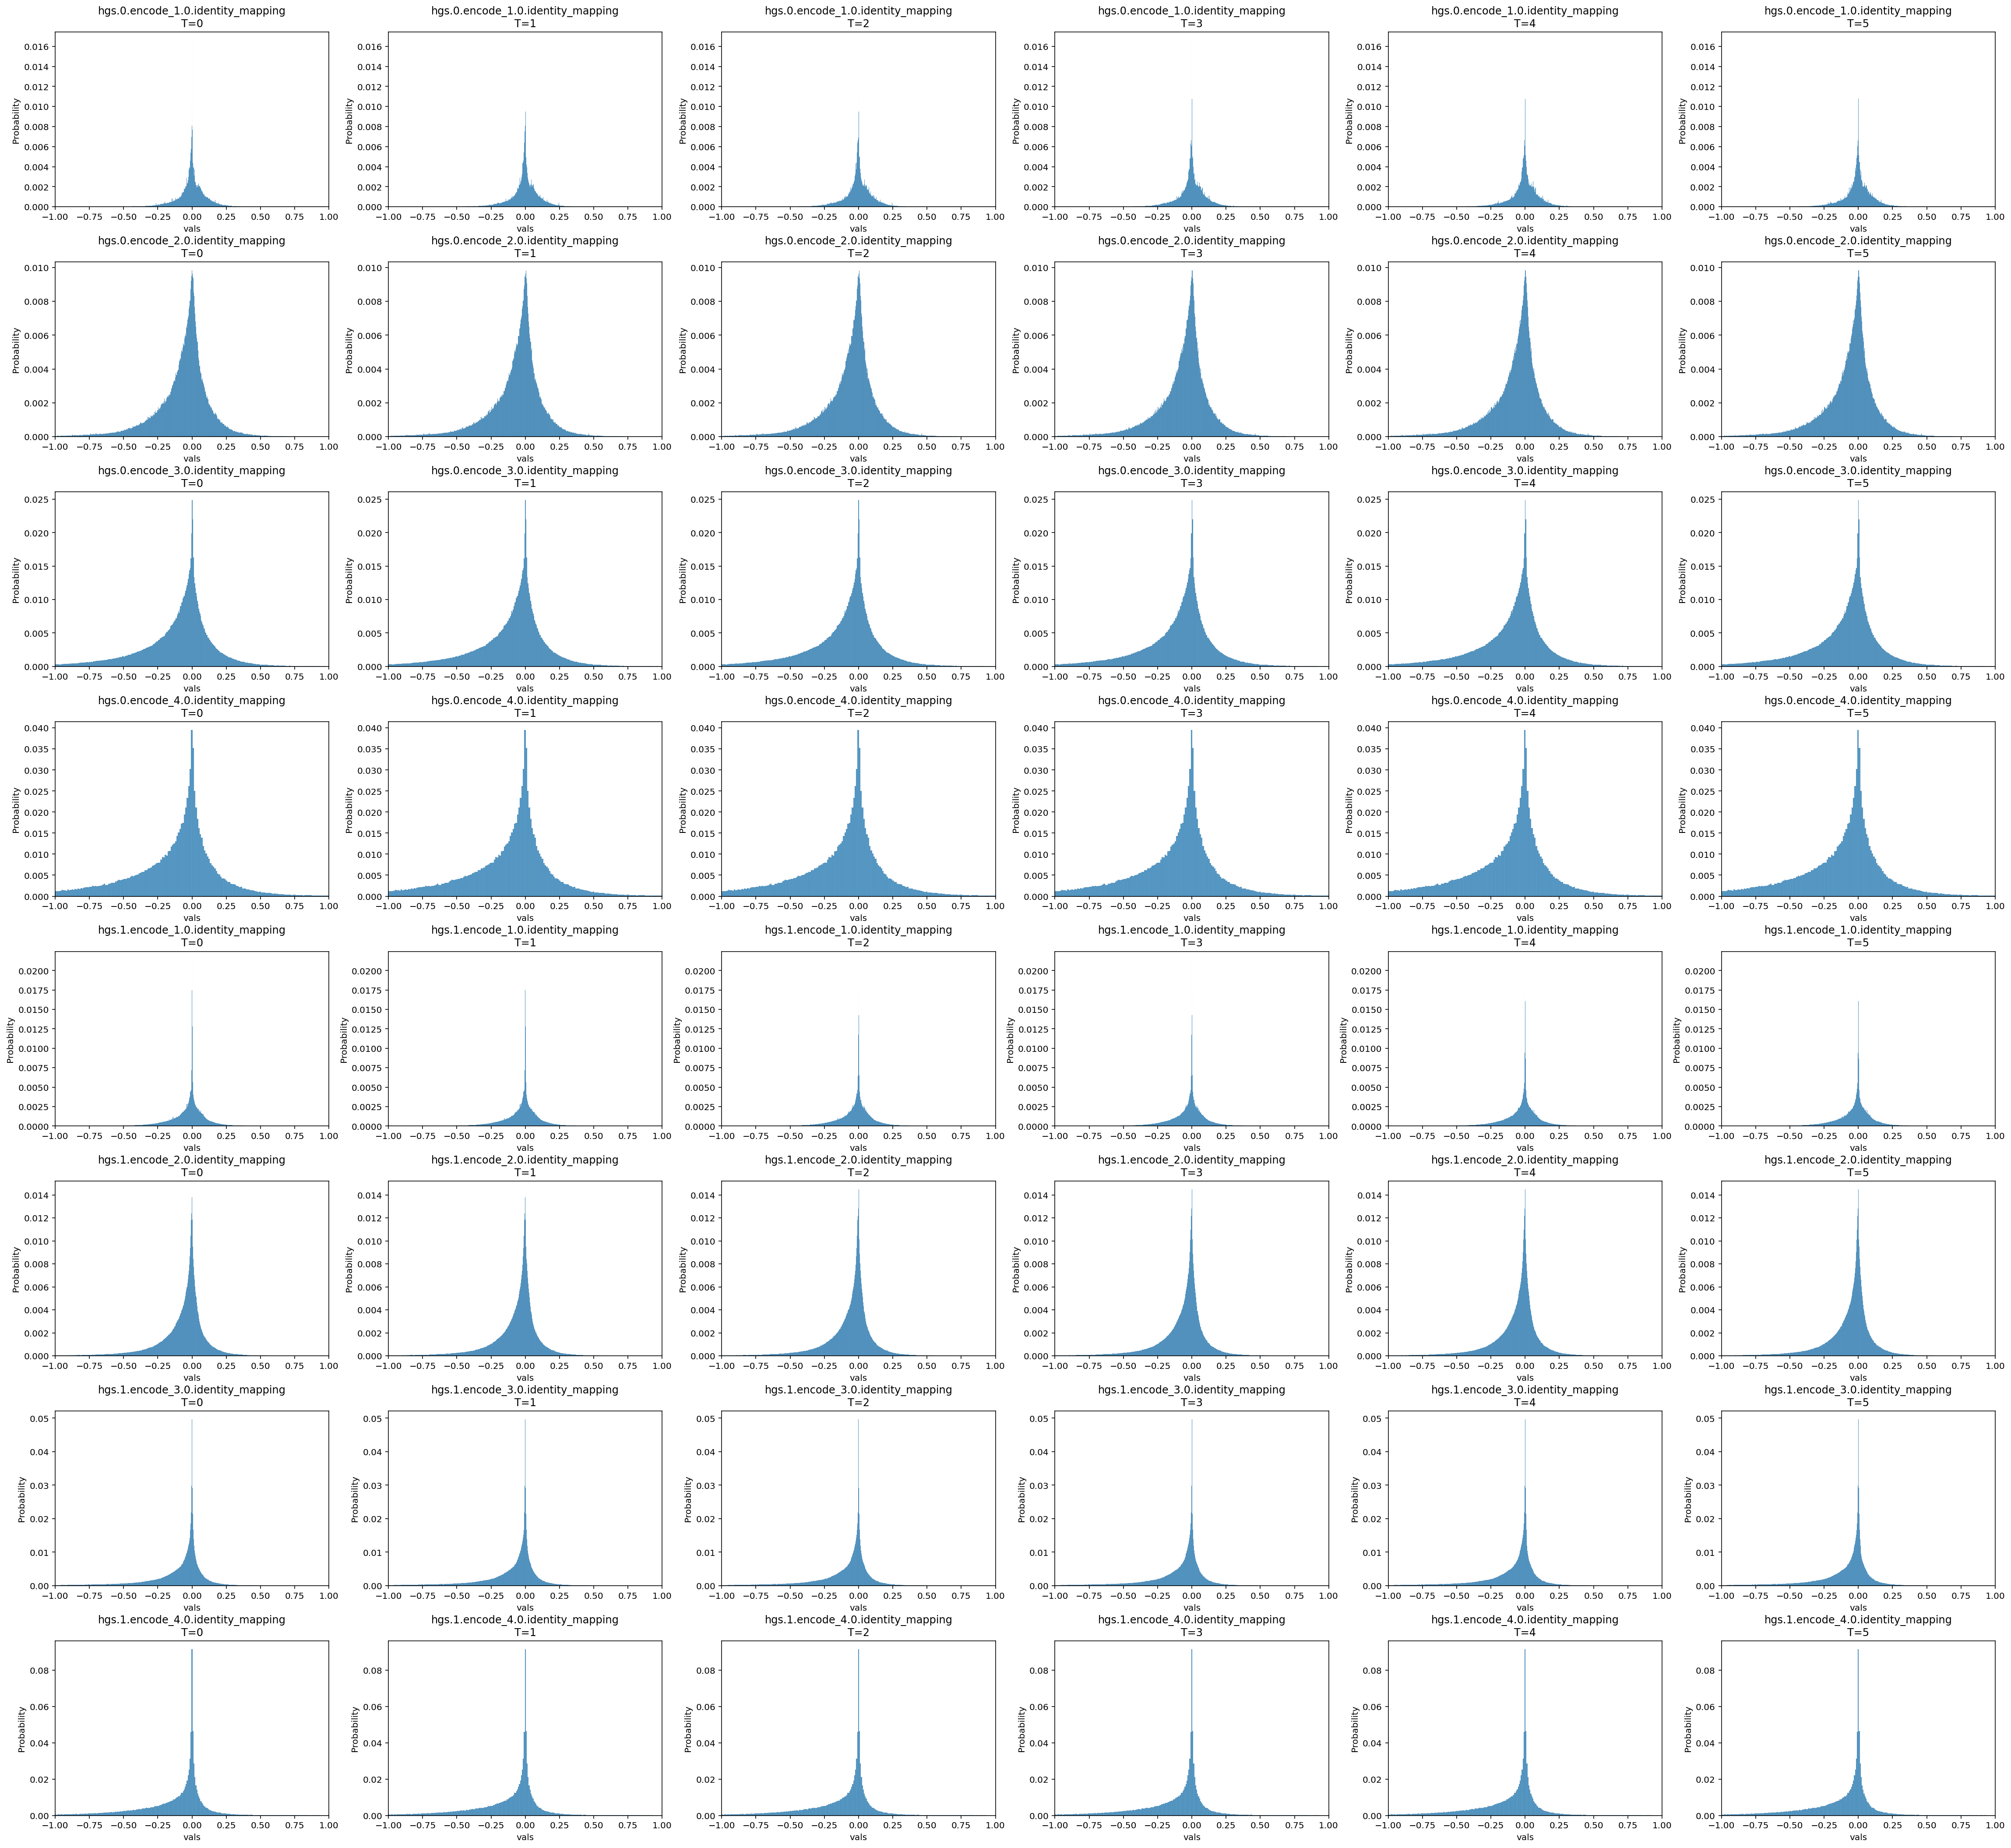

In [71]:
timesteps = df.t.unique().shape[0]
n_layers = df.layer.unique().shape[0]
fig, axes = plt.subplots(n_layers, timesteps, figsize=(32, 32))
for i, (layer, layer_df) in enumerate(df.groupby("layer")):
  for t, time_df in layer_df.groupby("t"):
    ax_t = axes[i][t]
    flat_vals = time_df.iloc[0].vals
    sns.histplot(x="vals", 
                 data=pd.DataFrame({"vals": flat_vals}), 
                 ax=ax_t, 
                 stat="probability")
    ax_t.set_title(f"{layer}\nT={t}")
    ax_t.set_xlim((-1, 1))
fig.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=0.1, w_pad=0.1)

In [ ]:
# net = pose_resnet.get_pose_net(config, is_train=False)

In [ ]:
net.timesteps

In [ ]:
n_params = count_parameters(net, trainable=False)
print(f"n_params: {n_params:,}")

In [ ]:
# X = torch.zeros((4, 3, 256, 256))

In [ ]:
X = torch.randint(0, 255, (4, 3, 256, 256)) / 255 * 2 - 1
X.min(), X.max()

In [ ]:
o = net(X, 3)

In [ ]:
for t in range(net.timesteps):
  print("T: ", t)
  o = net(X, t)
  print("\n")

In [ ]:
outs = []
for t in range(net.timesteps):
  print(t)
  out = net(X, t=t)
  outs.append(out)

In [ ]:
for t, out in enumerate(outs):
  x1 = out.sum()
  print(t, x1)